# Analysis of Drivers’ Behaviors using LTSM Model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras, lite
from tensorflow.keras.layers import Dense, Dropout, Flatten, ConvLSTM2D, LSTM, RepeatVector
import keras_tuner as kt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/driving-behavior/train_motion_data.csv
/kaggle/input/driving-behavior/test_motion_data.csv


## Description

Using LSTM deep leaning models to predict the drivers behaviors (Aggressive, Normal or Slow)

Sampling Rate: 2 samples (rows) per second.
Gravitational acceleration: removed.
Sensors: Accelerometer and Gyroscope.
Data:
Acceleration (X,Y,Z axis in meters per second squared (m/s2))
Rotation (X,Y, Z axis in degrees per second (°/s))
Classification label (SLOW, NORMAL, AGGRESSIVE)
Timestamp (time in seconds)
Driving Behaviors:
Slow
Normal
Aggressive

## EDA

Reading train and test data to start understanding how the datas look like

In [3]:
train_data = pd.read_csv('/kaggle/input/driving-behavior/train_motion_data.csv')

In [4]:
test_data = pd.read_csv('/kaggle/input/driving-behavior/test_motion_data.csv')

As the description says, the data has 3 acceleration features, 3 gyro features, one time feature and the classification of the data point called Class (Behavior)

For both train and test data, I will run the same visualizations and EDA's description
1. Screen shot of the data
2. Describe
3. Info
4. Histograms
5. Pie Chat proposion
6. Behavior by Accelation and Gyro over the timestamp

### Screen shot of the data

In [5]:
train_data

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Class,Timestamp
0,0.000000,0.000000,0.000000,0.059407,-0.174707,0.101938,NORMAL,3581629
1,-1.624864,-1.082492,-0.204183,-0.028558,0.051313,0.135536,NORMAL,3581630
2,-0.594660,-0.122410,0.220502,-0.019395,-0.029322,0.087888,NORMAL,3581630
3,0.738478,-0.228456,0.667732,0.069791,-0.029932,0.054902,NORMAL,3581631
4,0.101741,0.777568,-0.066730,0.030696,-0.003665,0.054902,NORMAL,3581631
...,...,...,...,...,...,...,...,...
3639,0.915688,-2.017489,1.687505,0.450360,0.384845,-1.236468,SLOW,3583789
3640,-1.934203,0.914925,-0.096013,0.321468,0.649350,-0.477162,SLOW,3583790
3641,-0.222845,0.747304,-0.887430,0.361174,-0.406836,0.054291,SLOW,3583790
3642,-0.349423,0.067261,0.394368,-0.132405,0.020159,-0.004963,SLOW,3583791


In [6]:
train_data[train_data['Class'] == 'NORMAL']

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Class,Timestamp
0,0.000000,0.000000,0.000000,0.059407,-0.174707,0.101938,NORMAL,3581629
1,-1.624864,-1.082492,-0.204183,-0.028558,0.051313,0.135536,NORMAL,3581630
2,-0.594660,-0.122410,0.220502,-0.019395,-0.029322,0.087888,NORMAL,3581630
3,0.738478,-0.228456,0.667732,0.069791,-0.029932,0.054902,NORMAL,3581631
4,0.101741,0.777568,-0.066730,0.030696,-0.003665,0.054902,NORMAL,3581631
...,...,...,...,...,...,...,...,...
1195,-0.820672,2.556599,-0.617599,-0.031612,-0.865596,-0.962189,NORMAL,3582274
1196,-0.016871,1.171574,0.603792,0.253662,0.692110,0.537485,NORMAL,3582275
1197,2.488864,-1.001262,0.432143,0.140041,-0.080023,0.051847,NORMAL,3582275
1198,-0.680338,-0.048300,-3.298533,-0.169057,-0.383012,0.217392,NORMAL,3582276


In [7]:
test_data

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Class,Timestamp
0,0.758194,-0.217791,0.457263,0.000000,0.000000,0.000000,AGGRESSIVE,818922
1,0.667560,-0.038610,0.231416,-0.054367,-0.007712,0.225257,AGGRESSIVE,818923
2,2.724449,-7.584121,2.390926,0.023824,0.013668,-0.038026,AGGRESSIVE,818923
3,2.330950,-7.621754,2.529024,0.056810,-0.180587,-0.052076,AGGRESSIVE,818924
4,2.847215,-6.755621,2.224640,-0.031765,-0.035201,0.035277,AGGRESSIVE,818924
...,...,...,...,...,...,...,...,...
3079,-0.713858,-0.652975,-0.164015,-0.147829,-1.309466,0.517250,SLOW,820706
3080,1.514261,0.330070,1.020714,1.321302,1.707598,-0.674548,SLOW,820707
3081,1.280216,-1.735172,-2.332695,0.583376,0.690507,-0.468075,SLOW,820707
3082,0.912313,0.583314,-0.965622,0.235794,0.512745,0.406073,SLOW,820708


### Describe

In [8]:
train_data.describe()

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Timestamp
count,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3.644000e+03
mean,0.040467,-0.073418,0.008271,0.001593,-0.001273,0.007949,3.582707e+06
std,0.985653,0.903408,0.985061,0.066918,0.126205,0.115687,6.421479e+02
min,-4.636523,-4.699795,-7.143998,-0.751822,-1.587028,-1.236468,3.581629e+06
25%,-0.550695,-0.592540,-0.558464,-0.028558,-0.053756,-0.029398,3.582121e+06
50%,0.003931,-0.080833,0.002262,0.001985,-0.001833,0.002978,3.582702e+06
75%,0.595987,0.452401,0.556157,0.031918,0.051313,0.040852,3.583270e+06
max,4.985548,4.245151,5.171739,0.849255,1.679879,1.190500,3.583791e+06


In [9]:
test_data.describe()

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Timestamp
count,3084.000000,3084.000000,3084.000000,3084.000000,3084.000000,3084.000000,3084.000000
mean,0.106234,-0.131791,0.045011,0.003192,0.001452,0.011472,819830.000324
std,0.968089,0.904398,0.997625,0.066636,0.120963,0.113535,525.760733
min,-4.854163,-7.621754,-6.106982,-0.514959,-1.309466,-0.976315,818922.000000
25%,-0.408916,-0.625868,-0.461438,-0.024435,-0.045739,-0.027031,819338.000000
50%,0.051892,-0.096929,0.054154,0.001222,-0.000993,0.002291,819832.500000
75%,0.579148,0.393118,0.575119,0.028100,0.043601,0.035888,820292.250000
max,5.864980,4.308813,5.564037,1.490511,1.707598,0.719447,820709.000000


### Info

In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3644 entries, 0 to 3643
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AccX       3644 non-null   float64
 1   AccY       3644 non-null   float64
 2   AccZ       3644 non-null   float64
 3   GyroX      3644 non-null   float64
 4   GyroY      3644 non-null   float64
 5   GyroZ      3644 non-null   float64
 6   Class      3644 non-null   object 
 7   Timestamp  3644 non-null   int64  
dtypes: float64(6), int64(1), object(1)
memory usage: 227.9+ KB


In [11]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3084 entries, 0 to 3083
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AccX       3084 non-null   float64
 1   AccY       3084 non-null   float64
 2   AccZ       3084 non-null   float64
 3   GyroX      3084 non-null   float64
 4   GyroY      3084 non-null   float64
 5   GyroZ      3084 non-null   float64
 6   Class      3084 non-null   object 
 7   Timestamp  3084 non-null   int64  
dtypes: float64(6), int64(1), object(1)
memory usage: 192.9+ KB


### Histograms

In [12]:
columns_train = train_data.columns.values.tolist()

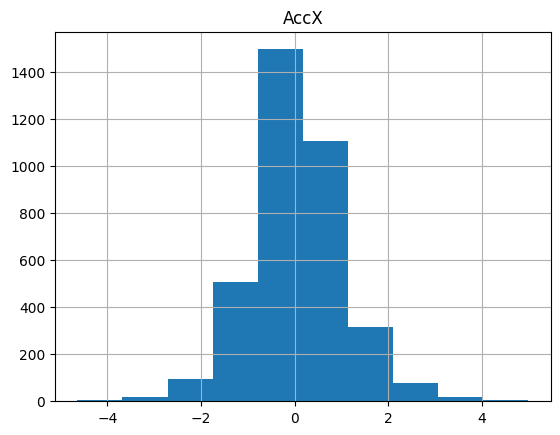

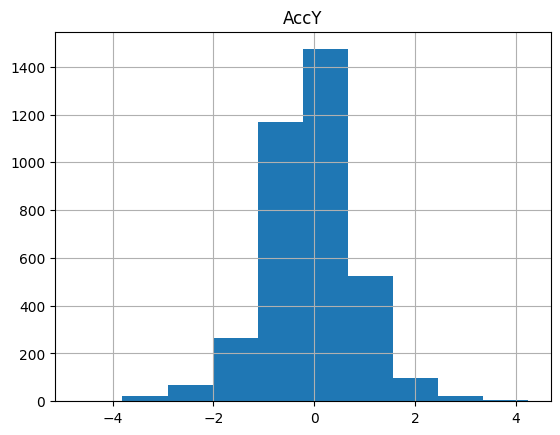

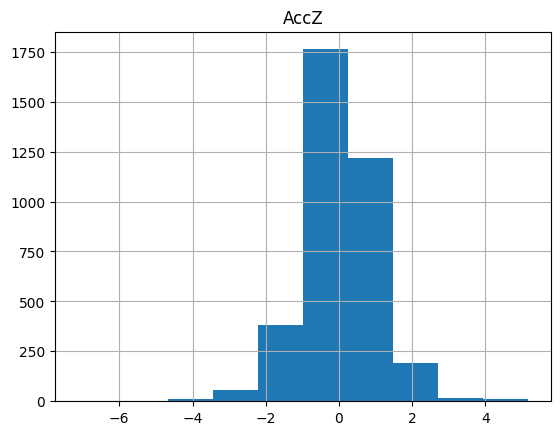

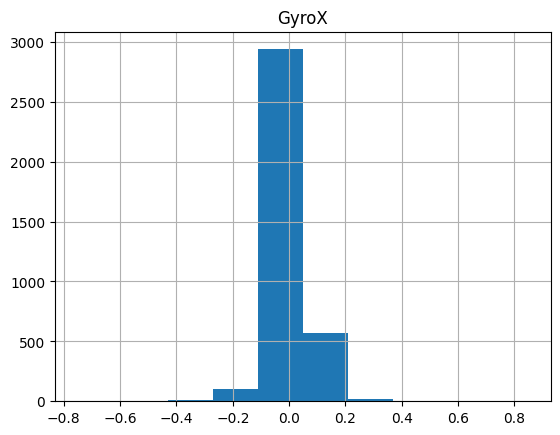

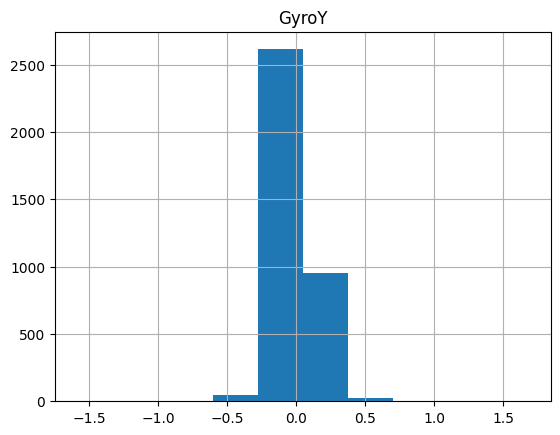

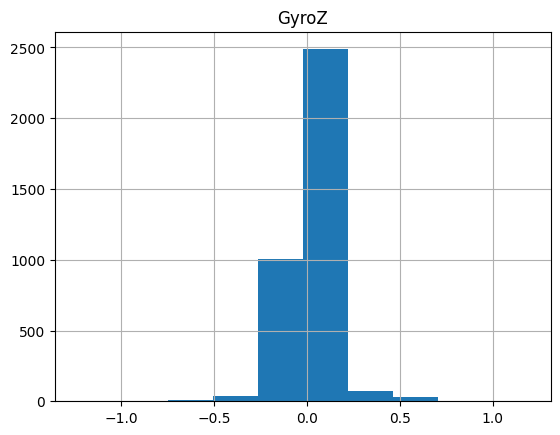

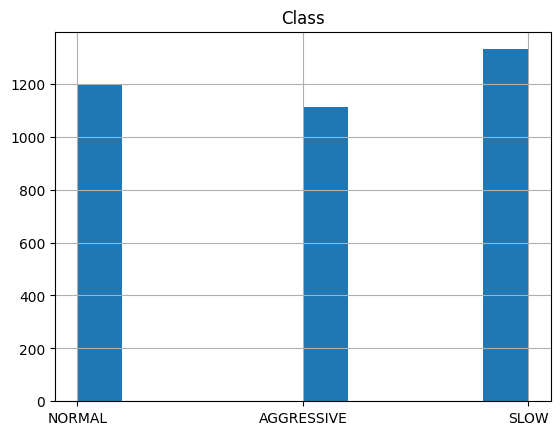

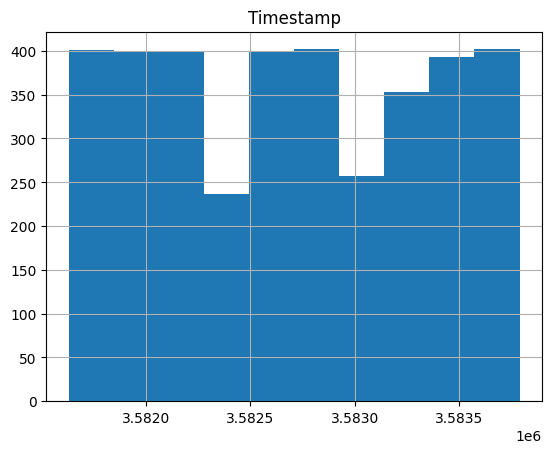

In [13]:
for c in columns_train:
    train_data[c].hist()
    plt.title(c)
    plt.show()

In [14]:
columns_test = test_data.columns.values.tolist()

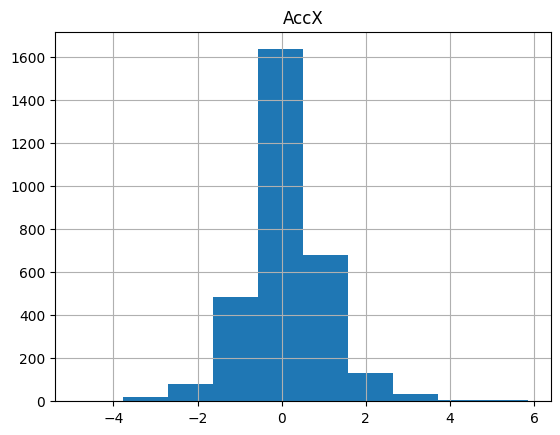

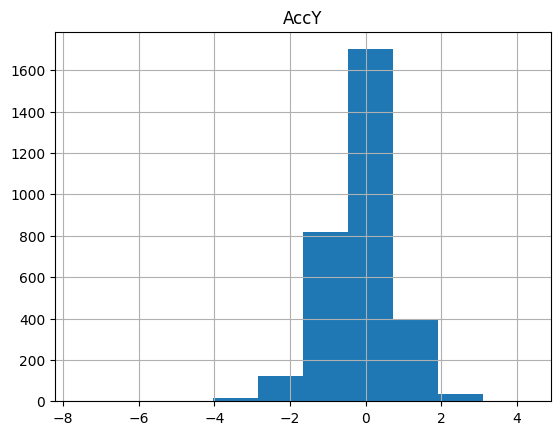

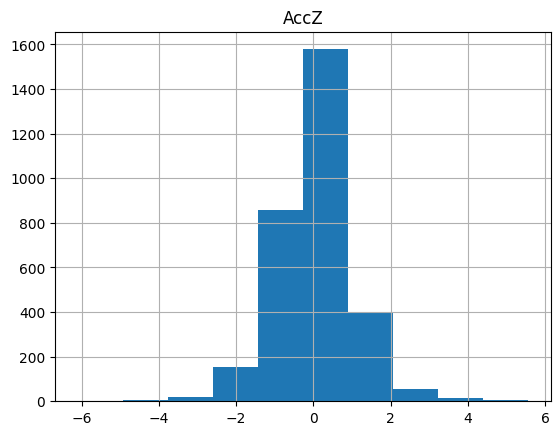

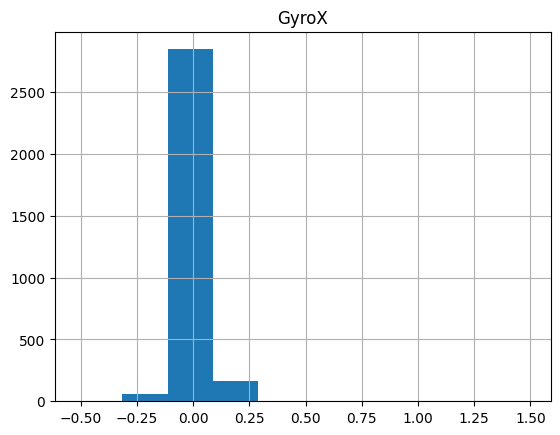

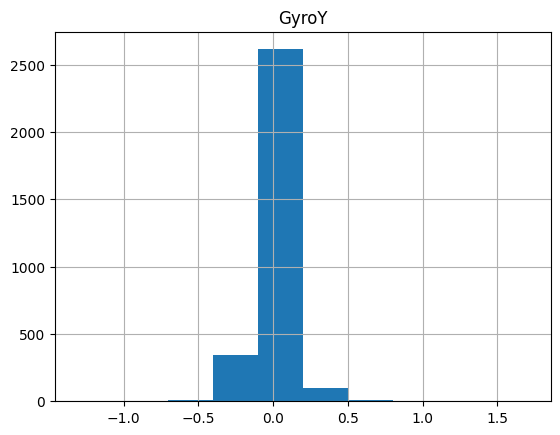

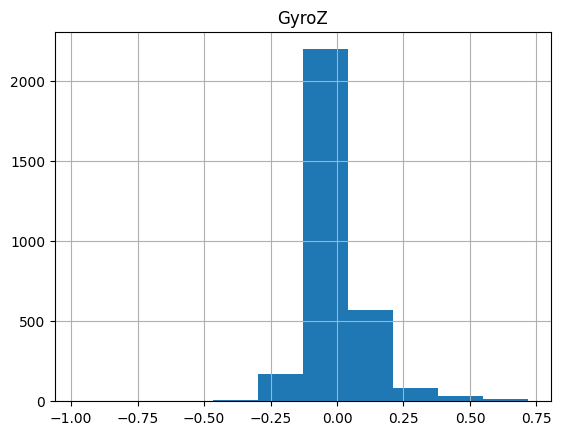

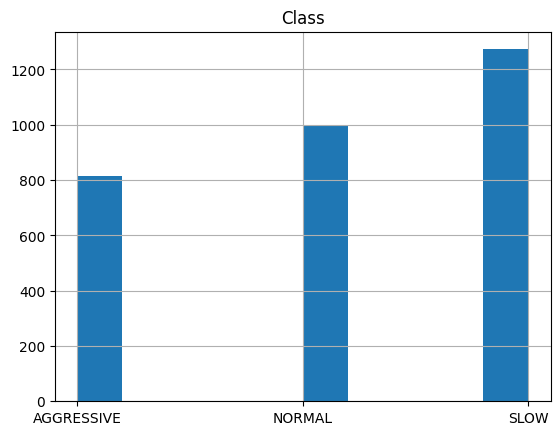

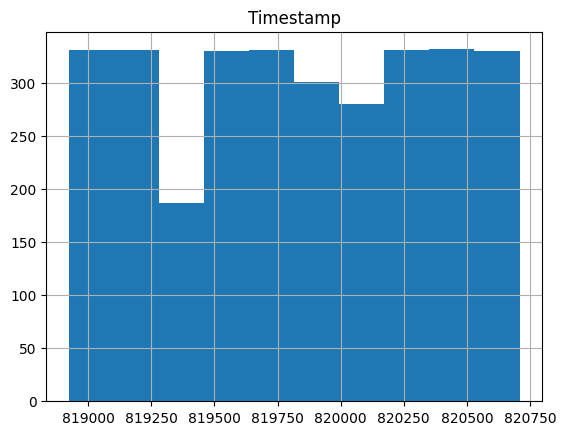

In [15]:
for ct in columns_test:
    test_data[ct].hist()
    plt.title(ct)
    plt.show()

### Pie charts

In [16]:
label_count_train = train_data['Class'].value_counts()

In [17]:
train_data['Class'].unique()

array(['NORMAL', 'AGGRESSIVE', 'SLOW'], dtype=object)

Text(0.5, 1.0, 'Behavior Propotion')

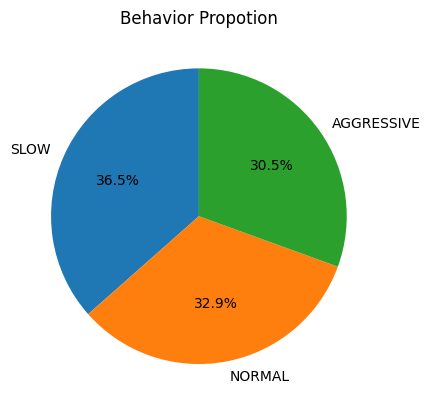

In [18]:
plt.pie(label_count_train, labels = ['SLOW','NORMAL','AGGRESSIVE'], startangle=90, autopct='%1.1f%%')
plt.title('Behavior Propotion')

In [19]:
label_count_test = test_data['Class'].value_counts()

Text(0.5, 1.0, 'Behavior Propotion')

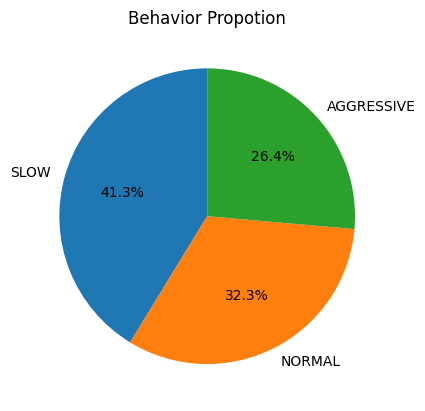

In [20]:
plt.pie(label_count_test, labels = ['SLOW','NORMAL','AGGRESSIVE'], startangle=90, autopct='%1.1f%%')
plt.title('Behavior Propotion')

### Behavior over the timestamps

Function to generate all graph based on behavior class using all 6 features of the data by time

In [21]:
def timestamp(df,behavior,x,y,z):
    t = x[:3]
    plt.plot(df[df['Class'] == behavior]['Timestamp'], df[df['Class'] == behavior][x], label=x)
    plt.plot(df[df['Class'] == behavior]['Timestamp'], df[df['Class'] == behavior][y], label=y)
    plt.plot(df[df['Class'] == behavior]['Timestamp'], df[df['Class'] == behavior][z], label=z)

    plt.title("{behavior} driving {t}".format(behavior=behavior,t=t))
    plt.xlabel('Timestamp')
    plt.legend()
    plt.show()

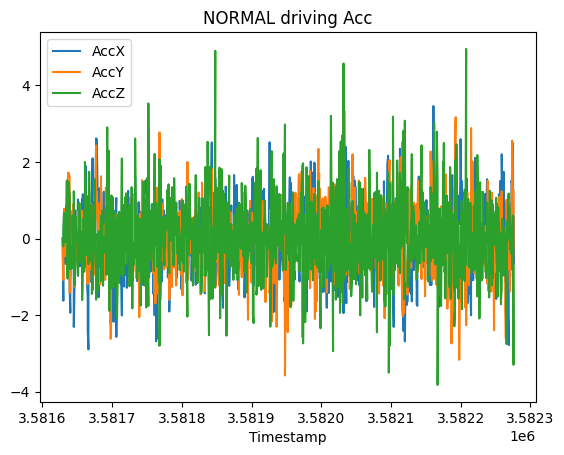

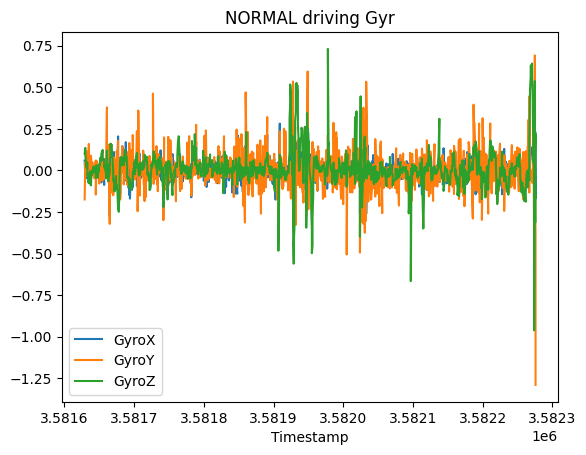

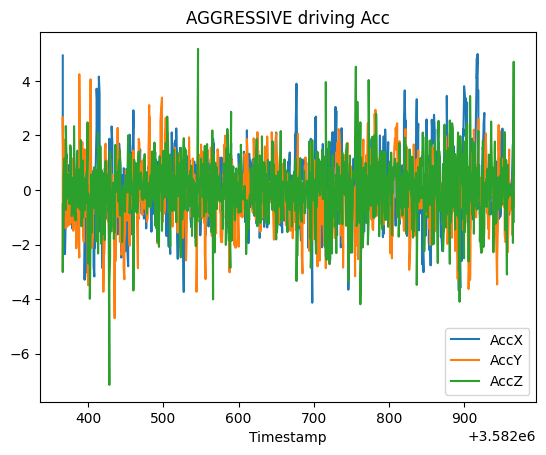

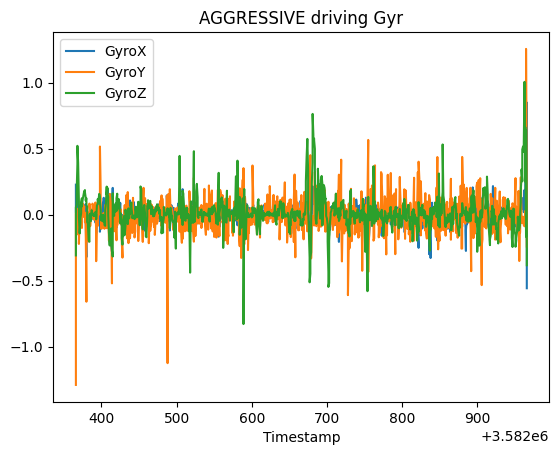

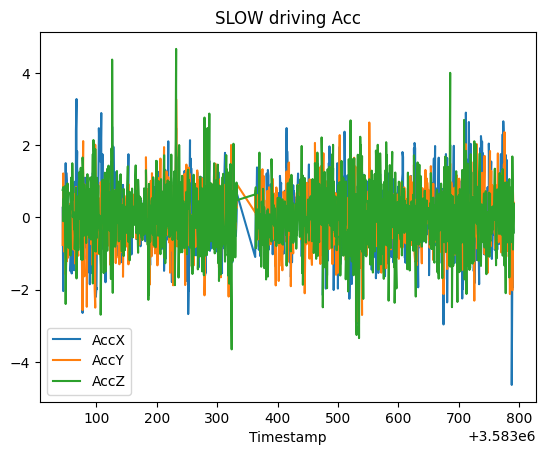

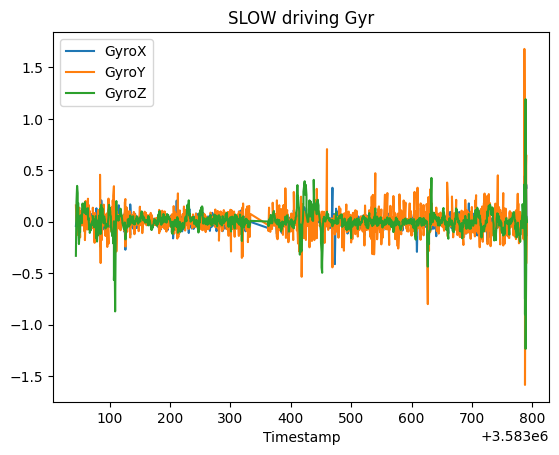

In [22]:
for behavior in train_data['Class'].unique():
    timestamp(train_data,behavior,"AccX","AccY","AccZ")
    timestamp(train_data,behavior,"GyroX","GyroY","GyroZ")

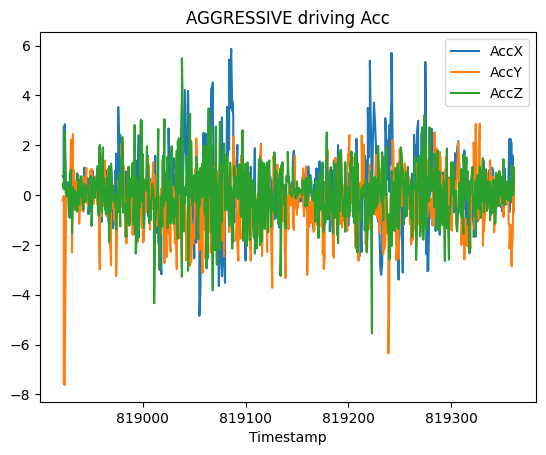

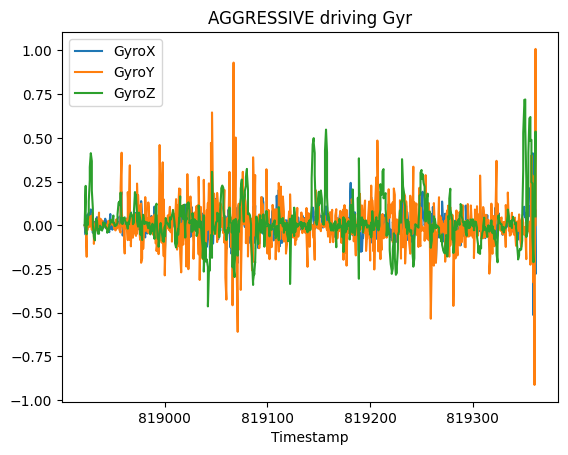

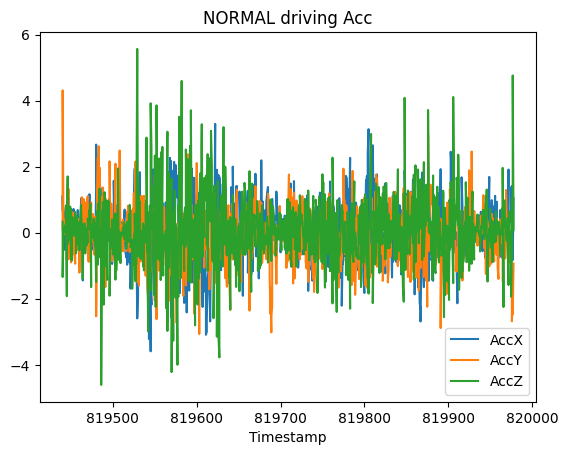

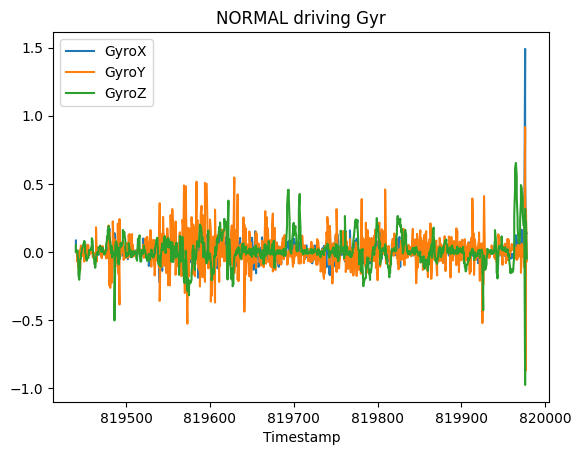

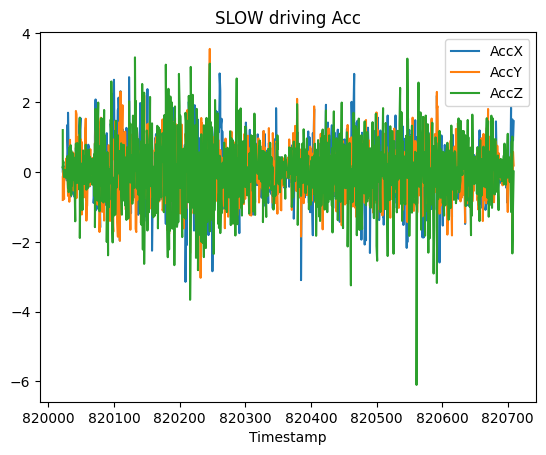

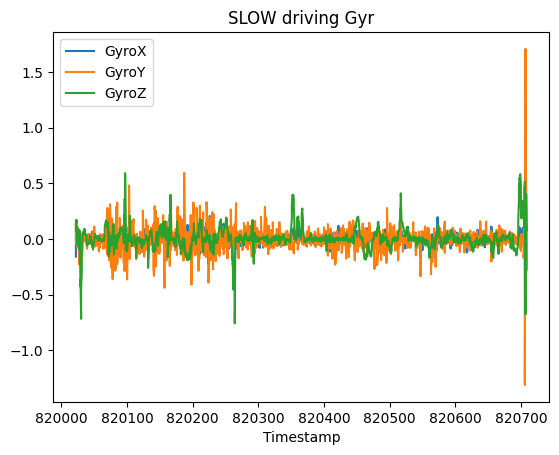

In [23]:
for behavior in test_data['Class'].unique():
    timestamp(test_data,behavior,"AccX","AccY","AccZ")
    timestamp(test_data,behavior,"GyroX","GyroY","GyroZ")

## Models

For both models, I will define the global constants to be able to process the data into the model.
1. Timesteps is the amount of samples to be fed to the NN, we will change this amount for both models
2. Features is the amount of features our data will have, it's 6 because we don't count the timestamp to train the model
3. Labels is the amount of labels we are considering when classifing the behavior, so we are keeping 3, the same the data has
4. Number of records will be use in the second model because of the clean up of noise we need to do
5. #columns, length and rows are the CNN constants to be able to shape into the model 

### LSTM 1

In [24]:
# Global constants
TIMESTEPS = 4 # the number of sample to be fed to the NN
FEATURES = 6
LABELS = 3
N_RECORDS = 11
# CNN constantS
N_COLUMNS = 2
N_LENGTH = TIMESTEPS // N_COLUMNS
N_ROWS = 1 # 1 for 1D data

Separating X (features) from y (labels) for both train and test data

In [25]:
X_train = train_data.iloc[: , :FEATURES]
y_train = train_data.Class
X_test = test_data.iloc[: , :FEATURES]
y_test = test_data.Class

In [26]:
X_train

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ
0,0.000000,0.000000,0.000000,0.059407,-0.174707,0.101938
1,-1.624864,-1.082492,-0.204183,-0.028558,0.051313,0.135536
2,-0.594660,-0.122410,0.220502,-0.019395,-0.029322,0.087888
3,0.738478,-0.228456,0.667732,0.069791,-0.029932,0.054902
4,0.101741,0.777568,-0.066730,0.030696,-0.003665,0.054902
...,...,...,...,...,...,...
3639,0.915688,-2.017489,1.687505,0.450360,0.384845,-1.236468
3640,-1.934203,0.914925,-0.096013,0.321468,0.649350,-0.477162
3641,-0.222845,0.747304,-0.887430,0.361174,-0.406836,0.054291
3642,-0.349423,0.067261,0.394368,-0.132405,0.020159,-0.004963


In [27]:
y_train

0       NORMAL
1       NORMAL
2       NORMAL
3       NORMAL
4       NORMAL
         ...  
3639      SLOW
3640      SLOW
3641      SLOW
3642      SLOW
3643      SLOW
Name: Class, Length: 3644, dtype: object

As ML/DL algorithms are working with numbers the labels should be mapped to numbers, so for our both models we will use label encoder to do that

In [28]:
labelEncoder = LabelEncoder()
y_train = labelEncoder.fit_transform(y_train)
y_test = labelEncoder.transform(y_test)

I will be using CategoricalCrossentropy loss function, so because of that I have to convert my labels to one-hot encoded vectors and both models will use that

In [29]:
y_train = to_categorical(y_train, num_classes=LABELS)
y_test = to_categorical(y_test, num_classes=LABELS)

I will use standard scaler to normalize my datasets because they contain variables that are different in scale and both models will utilize that

In [30]:
scaler = StandardScaler(with_mean=True, with_std=True)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [31]:
X_train

array([[-0.04106156,  0.08127915, -0.00839798,  0.86407394, -1.37441784,
         0.8125563 ],
       [-1.68980215, -1.11711676, -0.21570562, -0.45062488,  0.41672656,
         1.10301486],
       [-0.64445974, -0.05423733,  0.21547871, -0.31367708, -0.22227632,
         0.69109187],
       ...,
       [-0.26718077,  0.90859762, -0.9094098 ,  5.37422127, -3.21397144,
         0.40063334],
       [-0.39561936,  0.15574161,  0.39200552, -2.00269983,  0.16983909,
        -0.11162986],
       [-0.44940287,  0.53099161, -0.43788106, -0.82494886, -0.04316186,
        -0.05881923]])

In [32]:
X_test

array([[ 0.72827363, -0.15983063,  0.45586391, -0.02380426,  0.01008837,
        -0.06872122],
       [ 0.63630785,  0.03853461,  0.22655959, -0.83636115, -0.05102838,
         1.8786711 ],
       [ 2.72342227, -8.31488549,  2.41912118,  0.33225999,  0.1184042 ,
        -0.39746746],
       ...,
       [ 1.25796677, -1.83968002, -2.3767944 ,  8.69520504,  5.48215553,
        -4.1153363 ],
       [ 0.88465709,  0.72704944, -0.98879833,  3.50031885,  4.07344455,
         3.44186607],
       [ 1.44259613,  0.29194009,  0.01127534, -3.83095307, -2.20524253,
         0.59009151]])

Now it's time to reshape the input using the global constants defined previously for both train and test data for the Conv-LSTM network, both models will use that

In [33]:
train_samples = X_train.shape[0]//TIMESTEPS
X_train = X_train.reshape(train_samples, N_COLUMNS, N_ROWS, N_LENGTH, FEATURES)

test_samples = X_test.shape[0]//TIMESTEPS
X_test = X_test.reshape(test_samples, N_COLUMNS, N_ROWS, N_LENGTH, FEATURES)

print('Train features shape: ' + str(X_train.shape[0]))
print('Test features shape: ' + str(X_test.shape[0]))

Train features shape: 911
Test features shape: 771


In [34]:
y_train = y_train[::TIMESTEPS]
y_test = y_test[::TIMESTEPS]

print('Train labels shape: ' + str(y_train.shape[0]))
print('Test labels shape: ' + str(y_test.shape[0]))

Train labels shape: 911
Test labels shape: 771


We will start to construct the model by setting a global random seed for a better random result, then we build the model by assigning the number of layers and number of neurons for each layer, the learning rate, the number of epochs to get these optimal parameters I will use the Keras Tuner library after it will get the optimal parameters for the NN and pass it to the model_builder function, so the model will tune the learning rate for the optimizer and choose an optimal value from 0.1, 0.01, 0.001, or 0.0001

For hidden layers, I am using relu which is basic for this kind of model and the output activation fuction is softmax because it is a multi-classification model

In [35]:
tf.random.set_seed(42)
def model_builder(hp):
    model = tf.keras.Sequential()

    model.add(
        ConvLSTM2D(
            filters=hp.Int('filter_units', min_value=16, max_value=64, step=16),
            kernel_size=(1,2), 
            activation='relu', 
            input_shape=(N_COLUMNS, N_ROWS, N_LENGTH, FEATURES)
            )
        )
        
    model.add(Dropout(hp.Float('dropout_0_rate', min_value=0, max_value=0.5, step=0.1)))

    model.add(Flatten())

    model.add(Dense(hp.Int('dense_units', min_value=32, max_value=512, step=32), activation='relu'))

    model.add(Dense(LABELS, activation='softmax'))
    

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4])

    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        metrics=[
            tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )

    return model

To be able to get the optimal parameters for our network we have to create a Tuner with the following setup
'objective' -> will use to create test models
'max_epochs -> the maximum number of epochs to train one model
'factor' -> the reduction factor for the number of epochs and number of models for each bracket
'directory' -> will save the training history there

In [36]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=50,
                     factor=3,
                     directory='conv_lstm_dir',
                     project_name='driving_behavior')

Define an event that will stop the training depending of the value of "val_loss". it will stop training if the "val_loss" hasn't improved in 5 epochs.

In [37]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

The algorithm trains a large number of models for a few epochs and carries forward only the top-performing half of models to the next round.

In [38]:
tuner.search(
        x=X_train,
        y=y_train,
        epochs=50,
        validation_data=(X_test, y_test),
        callbacks=[stop_early], 
        shuffle=True
)

Trial 90 Complete [00h 00m 18s]
val_accuracy: 0.4734111428260803

Best val_accuracy So Far: 0.5162127017974854
Total elapsed time: 00h 09m 58s


Get best hyperparameters that were found during the search

In [39]:
best_model = tuner.get_best_models()[0]

Get the metrics for our trained model

In [40]:
eval_result = best_model.evaluate(X_test, y_test)

25/25 [==============================] - 1s 3ms/step - loss: 1.0140 - accuracy: 0.5162 - precision: 0.6015 - recall: 0.1038


Get the predictions

In [41]:
y_pred=best_model.predict(x=X_test)

25/25 [==============================] - 0s 2ms/step


Transform the predicted scores array to a pretty Dataframe

In [42]:
df_predicted = pd.DataFrame(y_pred, columns=['AGGRESSIVE', 'NORMAL', 'SLOW'])
df_predicted

,AGGRESSIVE,NORMAL,SLOW
0,1.000000,3.313723e-07,1.652094e-09
1,0.999759,2.328326e-04,7.852182e-06
2,0.373280,3.299912e-01,2.967286e-01
3,0.591523,2.241867e-01,1.842907e-01
4,0.279780,3.695998e-01,3.506198e-01
...,...,...,...
766,0.547691,2.953334e-01,1.569758e-01
767,0.215018,3.866183e-01,3.983636e-01
768,0.351208,3.523715e-01,2.964208e-01
769,0.831054,1.259782e-01,4.296774e-02


Reverse the one hot encoded vector and Transform the given class array to a Dataframe

In [43]:
actual_y_test = np.argmax(y_test, axis=1)
array_actual = labelEncoder.inverse_transform(actual_y_test)
df_actual = pd.DataFrame(array_actual, columns = ['Original Class'])

df_actual

,Original Class
0,AGGRESSIVE
1,AGGRESSIVE
2,AGGRESSIVE
3,AGGRESSIVE
4,AGGRESSIVE
...,...
766,SLOW
767,SLOW
768,SLOW
769,SLOW


Combine the actual and resulted classes

In [44]:
df_result = pd.concat([df_predicted, df_actual], axis=1)
df_result

,AGGRESSIVE,NORMAL,SLOW,Original Class
0,1.000000,3.313723e-07,1.652094e-09,AGGRESSIVE
1,0.999759,2.328326e-04,7.852182e-06,AGGRESSIVE
2,0.373280,3.299912e-01,2.967286e-01,AGGRESSIVE
3,0.591523,2.241867e-01,1.842907e-01,AGGRESSIVE
4,0.279780,3.695998e-01,3.506198e-01,AGGRESSIVE
...,...,...,...,...
766,0.547691,2.953334e-01,1.569758e-01,SLOW
767,0.215018,3.866183e-01,3.983636e-01,SLOW
768,0.351208,3.523715e-01,2.964208e-01,SLOW
769,0.831054,1.259782e-01,4.296774e-02,SLOW


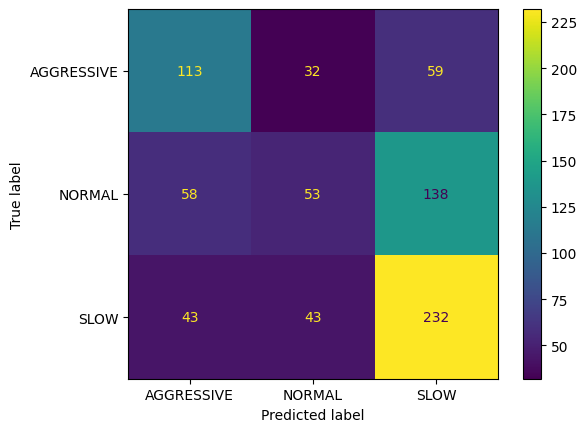

In [45]:
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(actual_y_test, y_pred)

classes = ['AGGRESSIVE', 'NORMAL', 'SLOW']
disp = ConfusionMatrixDisplay.from_predictions(actual_y_test, y_pred, display_labels=classes)

plt.rcParams['figure.figsize'] = [20, 10]
plt.show()

### LSTM 2

The model 2 we will clean the data noises that we noticed in the data when we plot the timestamp graphs. We will increase the batch into the model, change the number of columns and the length.

In [46]:
TIMESTEPS = 20 # the number of sample to be fed to the NN
FEATURES = 6
LABELS = 3
# CNN constantS
N_COLUMNS = 4
N_LENGTH = TIMESTEPS // N_COLUMNS
N_ROWS = 1 # 1 for 1D data

Split the samples by class so it can be trimmed to a desired shape

In [47]:
df_train_normal = train_data.loc[train_data['Class'] == 'NORMAL']
df_train_slow = train_data.loc[train_data['Class'] == 'SLOW']
df_train_aggressive = train_data.loc[train_data['Class'] == 'AGGRESSIVE']

df_test_normal = test_data.loc[test_data['Class'] == 'NORMAL']
df_test_slow = test_data.loc[test_data['Class'] == 'SLOW']
df_test_aggressive = test_data.loc[test_data['Class'] == 'AGGRESSIVE']

As it may be noticed, there is some noice at the beggin and end of every time series. It is caused because of the class switching. A solution would be to just remove the first and last N samples

In [48]:
df_train_slow = df_train_slow.iloc[N_RECORDS:]
df_train_slow = df_train_slow.iloc[:-N_RECORDS]

df_test_slow = df_test_slow.iloc[N_RECORDS:]
df_test_slow = df_test_slow.iloc[:-N_RECORDS]

df_train_normal = df_train_normal.iloc[N_RECORDS:]
df_train_normal = df_train_normal.iloc[:-N_RECORDS]

df_test_normal = df_test_normal.iloc[N_RECORDS:]
df_test_normal = df_test_normal.iloc[:-N_RECORDS]

df_train_aggressive = df_train_aggressive.iloc[N_RECORDS:]
df_train_aggressive = df_train_aggressive.iloc[:-N_RECORDS]

df_test_aggressive = df_test_aggressive.iloc[N_RECORDS:]
df_test_aggressive = df_test_aggressive.iloc[:-N_RECORDS]

In [49]:
train_slow_samples = df_train_slow.__len__()
train_normal_samples = df_train_normal.__len__()
train_aggressive_samples = df_train_aggressive.__len__()

print('---Train---')
print('Slow samples: ' + str(train_slow_samples))
print('Normal samples: ' + str(train_normal_samples))
print('Aggressive samples: ' + str(train_aggressive_samples))

df_train_slow = df_train_slow.tail(1300)
df_train_normal = df_train_normal.tail(1160)
df_train_aggressive = df_train_aggressive.tail(1080)

---Train---
Slow samples: 1309
Normal samples: 1178
Aggressive samples: 1091


In [50]:
test_slow_samples = df_test_slow.__len__()
test_normal_samples = df_test_normal.__len__()
test_aggressive_samples = df_test_aggressive.__len__()

print('---Test---')
print('Slow samples: ' + str(test_slow_samples))
print('Normal samples: ' + str(test_normal_samples))
print('Aggressive samples: ' + str(test_aggressive_samples))

df_test_slow = df_test_slow.tail(1240)
df_test_normal = df_test_normal.tail(960)
df_test_aggressive = df_test_aggressive.tail(780)

---Test---
Slow samples: 1251
Normal samples: 975
Aggressive samples: 792


In [51]:
X_train_normal = df_train_normal.iloc[: , :FEATURES]
X_train_slow = df_train_slow.iloc[: , :FEATURES]
X_train_aggressive = df_train_aggressive.iloc[: , :FEATURES]

X_test_normal = df_test_normal.iloc[: , :FEATURES]
X_test_slow = df_test_slow.iloc[: , :FEATURES]
X_test_aggressive = df_test_aggressive.iloc[: , :FEATURES]

# Labels
y_train_normal = df_train_normal.Class
y_train_slow = df_train_slow.Class
y_train_aggressive = df_train_aggressive.Class

y_test_normal = df_test_normal.Class
y_test_slow = df_test_slow.Class
y_test_aggressive = df_test_aggressive.Class

Combine all the samples intro a train dataset

In [52]:
X_train_ = pd.concat([X_train_slow, X_train_normal, X_train_aggressive])
y_train_ = pd.concat([y_train_slow, y_train_normal, y_train_aggressive])

X_test_ = pd.concat([X_test_slow, X_test_normal, X_test_aggressive])
y_test_ = pd.concat([y_test_slow, y_test_normal, y_test_aggressive])

In [53]:
y_train_ = labelEncoder.fit_transform(y_train_)
y_test_ = labelEncoder.transform(y_test_)

In [54]:
y_train_ = to_categorical(y_train_, num_classes=LABELS)
y_test_ = to_categorical(y_test_, num_classes=LABELS)

In [55]:
X_train_ = scaler.fit_transform(X_train_)
X_test_ = scaler.transform(X_test_)

In [56]:
train_samples_ = X_train_.shape[0]//TIMESTEPS
X_train_ = X_train_.reshape(train_samples_, N_COLUMNS, N_ROWS, N_LENGTH, FEATURES)

test_samples_ = X_test_.shape[0]//TIMESTEPS
X_test_ = X_test_.reshape(test_samples_, N_COLUMNS, N_ROWS, N_LENGTH, FEATURES)

print('Train features shape: ' + str(X_train_.shape[0]))
print('Test features shape: ' + str(X_test_.shape[0]))

Train features shape: 177
Test features shape: 149


In [57]:
y_train_ = y_train_[::TIMESTEPS]
y_test_ = y_test_[::TIMESTEPS]

print('Train labels shape: ' + str(y_train_.shape[0]))
print('Test labels shape: ' + str(y_test_.shape[0]))

Train labels shape: 177
Test labels shape: 149


In [58]:
tf.random.set_seed(42)
def model_builder_(hp):
    model = tf.keras.Sequential()

    model.add(
        ConvLSTM2D(
            filters=hp.Int('filter_units', min_value=16, max_value=64, step=16),
            kernel_size=(1,3), 
            activation='relu', 
            input_shape=(N_COLUMNS, N_ROWS, N_LENGTH, FEATURES)
            )
        )
        
    model.add(Dropout(hp.Float('dropout_0_rate', min_value=0, max_value=0.5, step=0.1)))

    model.add(Flatten())

    model.add(Dense(hp.Int('dense_units', min_value=32, max_value=512, step=32), activation='relu'))

    model.add(Dense(LABELS, activation='softmax'))
    

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.1, 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4])

    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        metrics=[
            tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )

    return model

In [59]:
tuner_ = kt.Hyperband(model_builder_,
                     objective='val_accuracy',
                     max_epochs=50,
                     factor=3,
                     directory='conv_lstm_dir_',
                     project_name='driving_behavior_')

In [60]:
stop_early_ = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [61]:
tuner_.search(
        x=X_train_,
        y=y_train_,
        epochs=50,
        validation_data=(X_test_, y_test_),
        callbacks=[stop_early_], 
        shuffle=True
)

Trial 90 Complete [00h 00m 11s]
val_accuracy: 0.47651007771492004

Best val_accuracy So Far: 0.6107382774353027
Total elapsed time: 00h 08m 46s


In [62]:
best_model_ = tuner_.get_best_models()[0]

In [63]:
eval_result_ = best_model_.evaluate(X_test_, y_test_)

5/5 [==============================] - 1s 6ms/step - loss: 0.9187 - accuracy: 0.6107 - precision: 0.6667 - recall: 0.4295


In [64]:
y_pred_=best_model_.predict(x=X_test_)

5/5 [==============================] - 0s 3ms/step


In [65]:
df_predicted_ = pd.DataFrame(y_pred_, columns=['AGGRESSIVE', 'NORMAL', 'SLOW'])
df_predicted_

,AGGRESSIVE,NORMAL,SLOW
0,0.135477,0.364552,0.499970
1,0.185045,0.191595,0.623360
2,0.161753,0.390584,0.447663
3,0.230825,0.228416,0.540759
4,0.137337,0.477591,0.385071
...,...,...,...
144,0.475190,0.139735,0.385075
145,0.821731,0.159955,0.018314
146,0.365315,0.326049,0.308636
147,0.209480,0.174782,0.615738


In [66]:
actual_y_test_ = np.argmax(y_test_, axis=1)
array_actual_ = labelEncoder.inverse_transform(actual_y_test_)
df_actual_ = pd.DataFrame(array_actual_, columns = ['Original Class'])

df_actual_

,Original Class
0,SLOW
1,SLOW
2,SLOW
3,SLOW
4,SLOW
...,...
144,AGGRESSIVE
145,AGGRESSIVE
146,AGGRESSIVE
147,AGGRESSIVE


In [67]:
df_result_ = pd.concat([df_predicted_, df_actual_], axis=1)
df_result_

,AGGRESSIVE,NORMAL,SLOW,Original Class
0,0.135477,0.364552,0.499970,SLOW
1,0.185045,0.191595,0.623360,SLOW
2,0.161753,0.390584,0.447663,SLOW
3,0.230825,0.228416,0.540759,SLOW
4,0.137337,0.477591,0.385071,SLOW
...,...,...,...,...
144,0.475190,0.139735,0.385075,AGGRESSIVE
145,0.821731,0.159955,0.018314,AGGRESSIVE
146,0.365315,0.326049,0.308636,AGGRESSIVE
147,0.209480,0.174782,0.615738,AGGRESSIVE


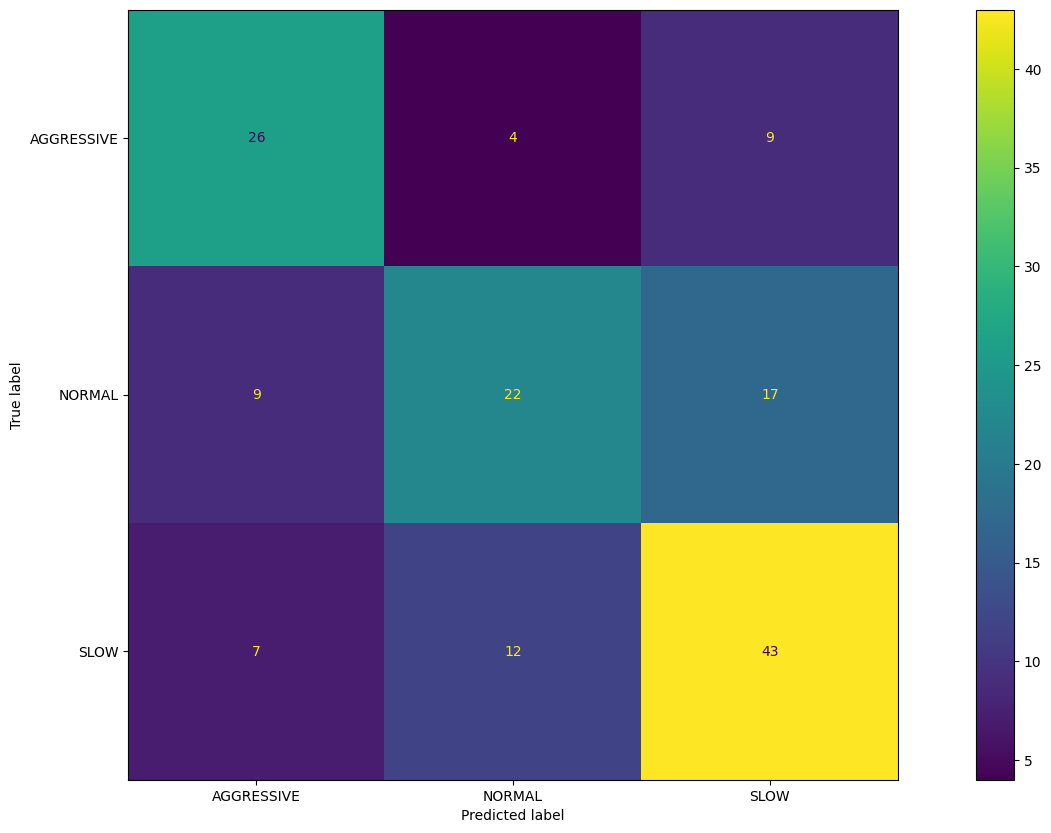

In [68]:
y_pred_ = np.argmax(y_pred_, axis=1)
cm_ = confusion_matrix(actual_y_test_, y_pred_)

classes = ['AGGRESSIVE', 'NORMAL', 'SLOW']
disp_ = ConfusionMatrixDisplay.from_predictions(actual_y_test_, y_pred_, display_labels=classes)

plt.rcParams['figure.figsize'] = [20, 10]
plt.show()

## Results

The indicators I decided to track were: Loss, Accuracy, Precision and Recall, the definition of all are below:
1. Loss - shows the comparation between the ML model prediction label and original label
2. Accuracy - shows how often a classification ML model is correct overall.
3. Precision - shows how often an ML model is correct when predicting the target class
4. Recall - shows whether an ML model can find all objects of the target class

|Model|Loss|Accuracy|Precision|Recall|
|------|------|------|------|------|
|1     |1.014     |0.5162     |0.6015     |0.1038     |
|2     |0.9187     |0.6107     |0.6667     |0.4295     |

The goal is to find if the behavior is aggressive or not, if I get only if the model predict the aggressive labels the results are below

|Model|Recall Aggresive|
|------|------|
|1     |0.5539     |
|2     |0.6667     |

So,model 1 predict 55.39% of the aggressive behaviors an Model 2 66.67%, even though the overall recall of model 1 is better than model 2

## Conclusion

The models created here is lacking in results, a model to predict drivers behavior has to perform better than showed above

Some suggestions can put in consideration to improve this model
1. Use 2 labels (Aggressive, not aggressive) instead of 3 and use sigmoid in the out put activation fuction istead of softmax
2. Dig into the data more to be able to clean even more
3. Don't shape the data smaller than the total data
4. Use other kinds of encoder to put a right weigh in a aggressive behavior comparing to Normal and Slow
5. Mix Deep Leaning with other kind of ML models for classification so the model can learn better
6. Split the train data into train and validation before fit the test to predict the labels
7. Increase the amount of Epochs for the model learning better